In [1]:
import openai as openai
import os
import json
from tqdm import tqdm
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel

api_key = ''
with open('../../openai.txt', 'r') as file:
    api_key = file.read().replace('\n', '')

client = openai.OpenAI(api_key=api_key)

In [2]:
def list_models():
    """
    List all available models in the OpenAI API.
    """
    models = client.models.list()
    print("Available models:")

    model_ids = []
    for model in models.data:
        model_ids.append(model.id)

    model_ids.sort()
    for model_id in model_ids:
        print(model_id)

# list_models(client)

In [3]:
def costs(prompt_tokens, completion_tokens):
    """
    Calculate the costs based on the number of tokens used.
    Args:
        prompt_tokens (int): The number of prompt tokens used.
        completion_tokens (int): The number of completion tokens used.
    Returns:
        float: The total cost in dollars.
    """
    if model_used == 'gpt-4o-mini':
        price_per_1m_input_tokens = 0.15
        price_per_1m_output_tokens = 0.6
    elif model_used == 'gpt-4o':
        price_per_1m_input_tokens = 2.5
        price_per_1m_output_tokens = 10
    elif model_used == 'o4-mini':
        price_per_1m_input_tokens = 1.10
        price_per_1m_output_tokens = 4.40
    else:
        raise ValueError(
            "Model not set or not supported for cost calculation.")
    total_cost = ((prompt_tokens / 1000000) * price_per_1m_input_tokens) + \
        ((completion_tokens / 1000000) * price_per_1m_output_tokens)
    return total_cost

In [ ]:
class StructuredResponse(BaseModel):
    bestIter: int
    explanation: str


def llm_call(prompt):
    """
    Call the OpenAI API to get a response based on the provided system and user prompts.
    Args:
        prompt (str): The prompt to send to the OpenAI API.
    Returns:
        tuple: A tuple containing the answer, prompt tokens, completion tokens, and total tokens.
    """
    global global_prompt_tokens, global_completion_tokens

    retries = 0
    max_completion_tokens = 2000
    while True:
        try:
            response = client.beta.chat.completions.parse(
                model=model_used,
                messages=[
                    {"role": "system", "content": prompt}
                ],
                max_completion_tokens=max_completion_tokens,
                response_format=StructuredResponse
            )
            break
        except openai.LengthFinishReasonError as e:
            # Retry with larger max_completion_tokens
            max_completion_tokens *= 2

            prompt_tokens += e.completion.usage.prompt_tokens
            completion_tokens += e.completion.usage.completion_tokens
            total_tokens += e.completion.usage.total_tokens

            global_prompt_tokens += e.completion.usage.prompt_tokens
            global_completion_tokens += e.completion.usage.completion_tokens
        except Exception as e:
            retries += 1
            backoff_time = (2 ** retries) + random.random()
            print(f"Retrying in {backoff_time:.2f} seconds...")
            time.sleep(backoff_time)

    prompt_tokens = response.usage.prompt_tokens
    completion_tokens = response.usage.completion_tokens
    total_tokens = response.usage.total_tokens

    global_prompt_tokens += response.usage.prompt_tokens
    global_completion_tokens += response.usage.completion_tokens

    answer = response.choices[0].message.parsed.model_dump()

    # Uncomment the following lines to simulate a mock response
    # answer = {
    #     "bestIter": random.randint(0, 10),
    #     "explanation": "This is a mock response."
    # }
    # prompt_tokens = 100
    # completion_tokens = 200
    # total_tokens = prompt_tokens + completion_tokens

    # global_prompt_tokens += prompt_tokens
    # global_completion_tokens += completion_tokens

    return answer, prompt_tokens, completion_tokens, total_tokens

In [5]:
def comparison(questions, topic, concepts, criteria, c_question, number, student_level, materials):
    prompt = f"""
    You are an expert teacher in the field of reflection questions. Your task is to evaluate which of the responses containing a single reflective question is the best based on given criteria. Not all key concepts need to be present in the question.
        
    The topic is {topic}.
    The key concepts are {concepts}
    The criteria is {criteria}: {c_question}

    Provide the index (0-10) of the response containing the best reflective question based on the criteria. Then provide a brief explanation of your choice (at most 2 sentences).
    """
    # Randomize the order of the questions to avoid bias
    questions_with_indices = list(enumerate(questions))
    random.shuffle(questions_with_indices)
    original_indices = [i for i, _ in questions_with_indices]
    randomized_questions = [q for _, q in questions_with_indices]

    for i, q in enumerate(randomized_questions):
        prompt += f"\nResponse {chr(65 + i)}:\n{q}"

    answer, pt, ct, tt = llm_call(prompt)

    # Get the number of the best question
    original_index = original_indices[answer['bestIter']]

    result = {}
    for i, q in enumerate(questions):
        result[f"question_{i}"] = q

    result.update({
        "attempt": number,
        "student_level": student_level,
        "materials": materials,
        "criteria": criteria,
        "bestIter": original_index,
        "explanation": answer['explanation'],
        "prompt_tokens": pt,
        "completion_tokens": ct,
        "total_tokens": tt
    }
    )
    return result

In [ ]:
def evaluation(file, topic, concepts):
    print("Starting the evaluation...")

    sources = None
    with open(file, 'r') as f:
        sources = json.load(f)

    if os.path.exists('fixed10_best_iter.csv'):
        os.remove('fixed10_best_iter.csv')

    # Criteria used for evaluation
    criteria = {
        "clarity": "Is the question clearly stated and easy to understand?",
        "relevance": "Is the question relevant to the topic?",
        "depth": "Does the question encourage critical thinking and deeper exploration of the topic?",
        "overall_quality": "Is the question of high quality overall, well-structured and thought-provoking?",
    }

    rows = []

    for j, item in tqdm(enumerate(sources), desc="Processing items", total=len(sources)):
        for c in criteria:
            questions = []

            for response in item['student']:
                if response['role'] == 'assistant':
                    questions.append(response['content'])

            number = item['metadata']['attempt']
            student_level = item['metadata']['student_level']
            materials = item['metadata']['materials']

            rows.append(comparison(questions, topic, concepts, c,
                        criteria[c], number, student_level, materials))

    bestIter = pd.DataFrame(rows)
    bestIter.to_csv('fixed10_best_iter.csv', index=False)

    print("All combinations have been evaluated.")

In [7]:
model_used = "o4-mini"

global_prompt_tokens = 0
global_completion_tokens = 0

# Experiment settings
file = 'fixed10iter.json'
topic = "Basics of how the internet works"
concepts = """
 - Decentralization of the internet
 - Servers, datacenters and routers
 - Server vs client
 - Data packets
 - IP addresses
"""
seed = 42
random.seed(seed)

evaluation(file, topic, concepts)

Starting the evaluation...


Processing items: 100%|██████████| 40/40 [24:07<00:00, 36.20s/it]

All combinations have been evaluated.


In [8]:
print("Total prompt tokens:", global_prompt_tokens)
print("Total completion tokens:", global_completion_tokens)
print(costs(global_prompt_tokens, global_completion_tokens))

Total prompt tokens: 336788
Total completion tokens: 117537
0.8876296


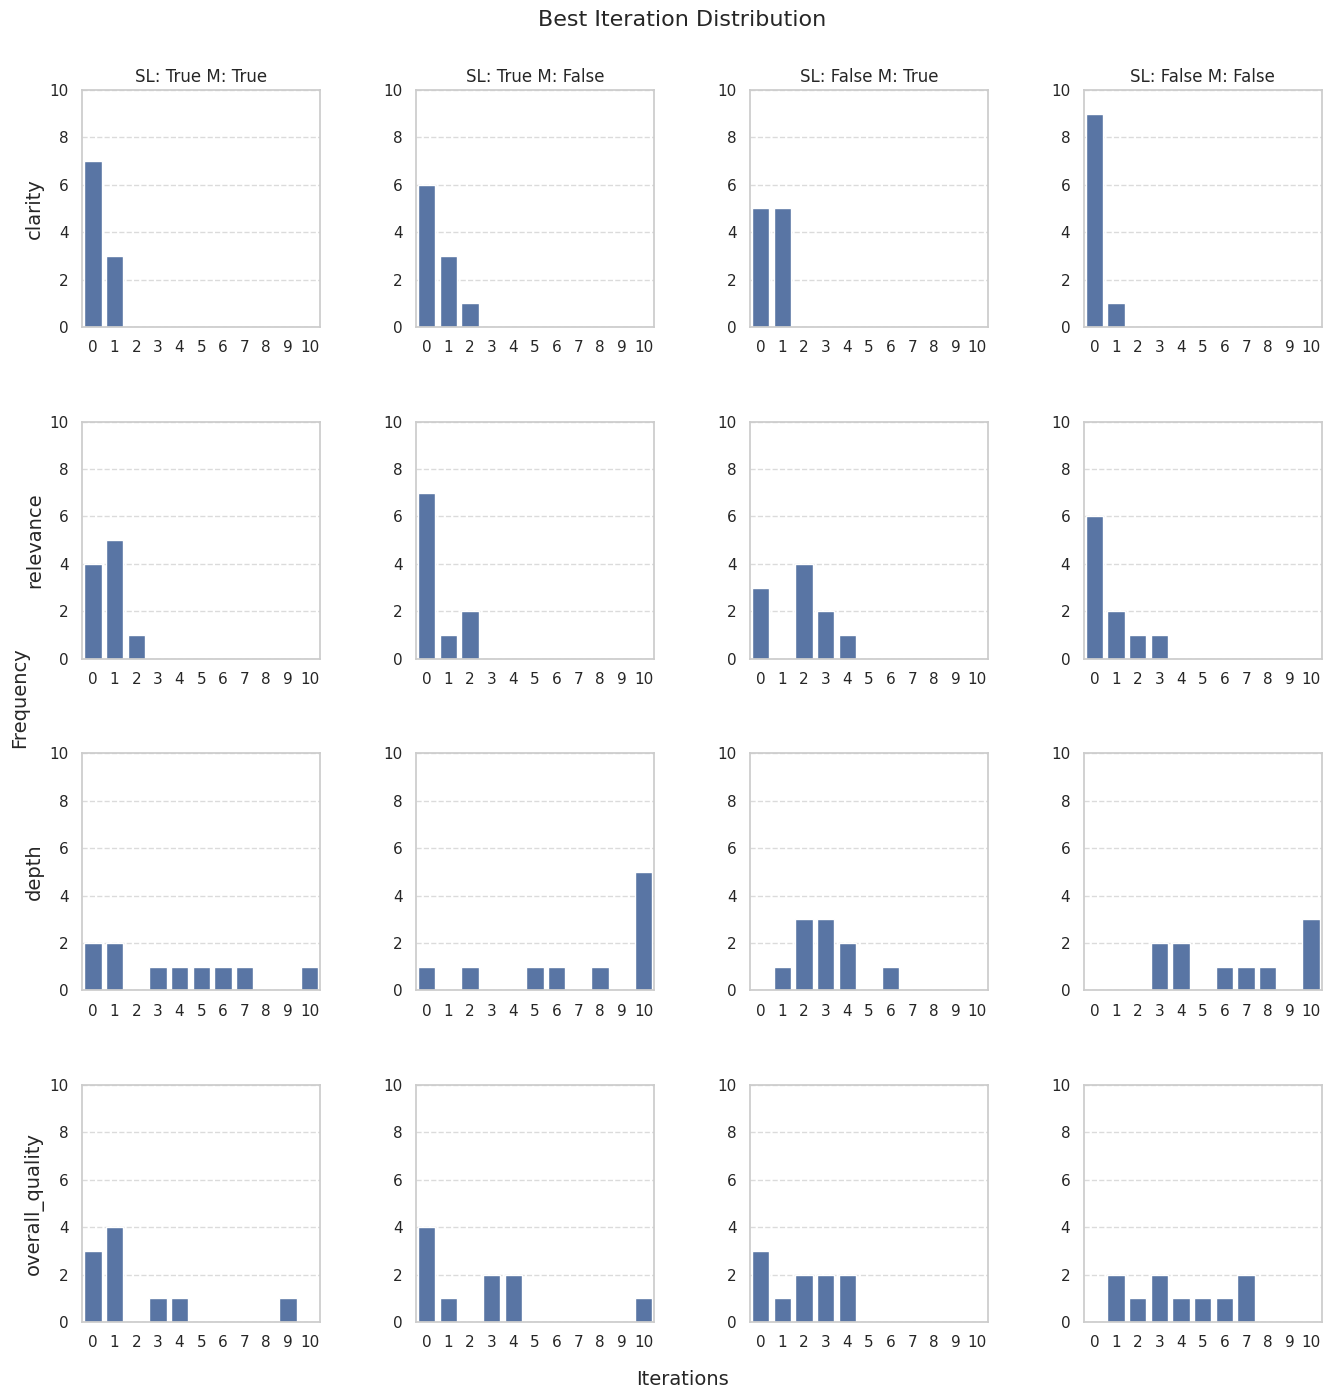

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

with open('fixed10_best_iter.csv', 'r') as file:
    data = pd.read_csv(file)

    fig, axs = plt.subplots(4, 4, figsize=(16, 16))

    for i, c in enumerate(data['criteria'].unique()):
        fig.suptitle(f"Best Iteration Distribution", fontsize=16, y=0.93)
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        if i == 0:
            fig.text(0.5, fig.subplotpars.bottom - 0.03,
                     "Iterations", ha='center', va='top', fontsize=14)
            fig.text(0.08, 0.5, "Frequency", va='center',
                     rotation='vertical', fontsize=14)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        for j, comb in enumerate(combinations):
            student_level = comb[0]
            materials = comb[1]

            # Filter the data for the current criteria
            subset = data[data['criteria'] == c]

            # Filter the data for the current combination
            subset = subset[subset['student_level'] == student_level]
            subset = subset[subset['materials'] == materials]

            bestIter = subset['bestIter'].value_counts()

            ax = axs[i, j]

            sns.barplot(
                x=bestIter.index,
                y=bestIter.values,
                ax=ax,
                order=range(0, 11),
            )

            ax.set_xlabel('')
            ax.set_ylabel('')

            # To only the first row add the title
            if i == 0:
                ax.set_title(
                    f"SL: {student_level} M: {materials}")

            # To the first column add the criteria
            if j == 0:
                ax.set_ylabel(c, fontsize=14)

            ax.set_xlim(-0.5, 10.5)
            ax.set_xticks(range(0, 11))
            # ax.set_xticklabels(
            #     ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

            ax.set_yticks(range(0, 11, 2))
            ax.set_ylim(0, 10)

            ax.grid(axis='y', linestyle='--', alpha=0.7)

    # plt.savefig('Images/fixed10_best_iter.png', dpi=300, bbox_inches='tight')
    plt.show()

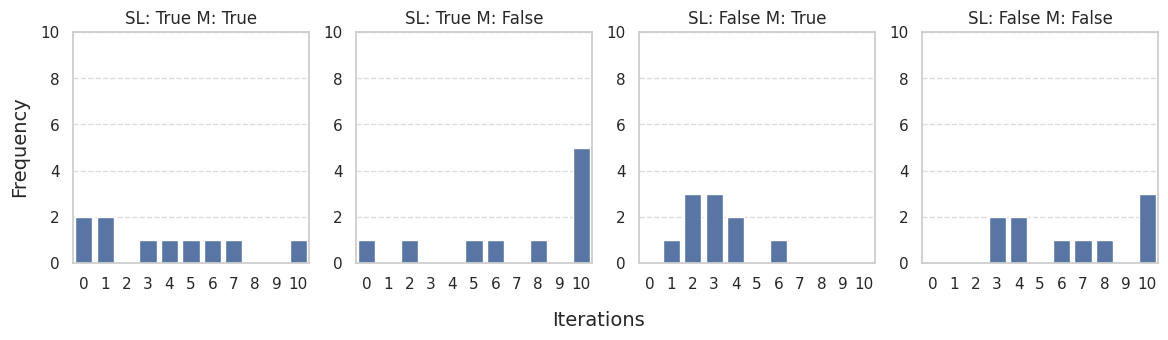

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

with open('fixed10_best_iter.csv', 'r') as file:
    data = pd.read_csv(file)

    fig, axs = plt.subplots(1, 4, figsize=(14, 3))

    for i, c in enumerate(['depth']):
        if i == 0:
            fig.text(0.5, -0.1, "Iterations", ha='center', fontsize=14)
            fig.text(0.08, 0.5, "Frequency", va='center',
                     rotation='vertical', fontsize=14)

        combinations = [[True, True], [True, False],
                        [False, True], [False, False]]

        for j, comb in enumerate(combinations):
            student_level = comb[0]
            materials = comb[1]

            # Filter the data for the current criteria
            subset = data[data['criteria'] == c]

            # Filter the data for the current combination
            subset = subset[subset['student_level'] == student_level]
            subset = subset[subset['materials'] == materials]

            bestIter = subset['bestIter'].value_counts()

            ax = axs[j]

            sns.barplot(
                x=bestIter.index,
                y=bestIter.values,
                ax=ax,
                order=range(0, 11),
            )

            ax.set_xlabel('')
            ax.set_ylabel('')

            # To only the first row add the title
            if i == 0:
                ax.set_title(
                    f"SL: {student_level} M: {materials}")

            ax.set_xlim(-0.5, 10.5)
            ax.set_xticks(range(0, 11))
            # ax.set_xticklabels(
            #     ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

            ax.set_yticks(range(0, 11, 2))
            ax.set_ylim(0, 10)

            ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.savefig('Images/fixed10_best_iter_depth.png', dpi=300, bbox_inches='tight')
    plt.show()